In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import os

# Paths to the dataset
train_dir = "./Dataset/train-plant-disease"
valid_dir = "./Dataset/valid-Plant-disease"


2024-06-12 11:00:06.205994: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 11:00:07.120786: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Enable GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[:2], 'GPU')
        print("GPUs are being used")
    except RuntimeError as e:
        print(e)
else:
    print("GPUs not found. Please check your CUDA and cuDNN installation.")

GPUs not found. Please check your CUDA and cuDNN installation.


2024-06-12 11:00:11.230025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 11:00:11.230247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 11:00:11.230709: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [4]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')


Found 38000 images belonging to 38 classes.
Found 11400 images belonging to 38 classes.


Base pre-trained model

In [10]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(38, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the new data for a few epochs
model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10


/home/mohi_566357/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1046s 877ms/step - accuracy: 0.5607 - loss: 1.6095 - val_accuracy: 0.8806 - val_loss: 0.3556
Epoch 2/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1002s 841ms/step - accuracy: 0.8167 - loss: 0.5825 - val_accuracy: 0.8975 - val_loss: 0.3102
Epoch 3/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1002s 842ms/step - accuracy: 0.8454 - loss: 0.5034 - val_accuracy: 0.9048 - val_loss: 0.2962
Epoch 4/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1002s 842ms/step - accuracy: 0.8622 - loss: 0.4598 - val_accuracy: 0.9039 - val_loss: 0.2985
Epoch 5/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1012s 850ms/step - accuracy: 0.8688 - loss: 0.4495 - val_accuracy: 0.9167 - val_loss: 0.2584
Epoch 6/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1013s 851ms/step - accuracy: 0.8763 - loss: 0.4345 - val_accuracy: 0.9252 - val_loss: 0.2278
Epoch 7/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1019s 856ms/step - accuracy: 0.8766 - loss: 0.4247 - val_accuracy: 0.9186 - val_loss: 0.2581
Epoch 8/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1017s 854ms/step - accur

Fine-tuning the model

In [11]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator)



0 input_layer
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_

Model Evaluation

In [13]:
evaluation = model.evaluate(valid_generator)
print(f'Validation loss: {evaluation[0]}')
print(f'Validation accuracy: {evaluation[1]}')

357/357 ━━━━━━━━━━━━━━━━━━━━ 230s 643ms/step - accuracy: 0.9836 - loss: 0.0458
Validation loss: 0.044545043259859085
Validation accuracy: 0.983859658241272


In [16]:
import matplotlib.pyplot as plt
import pickle

Save Training history and training model

In [18]:
# Save the training history
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Save the trained model
model.save('plant_disease_model.keras')

Plotting Graph

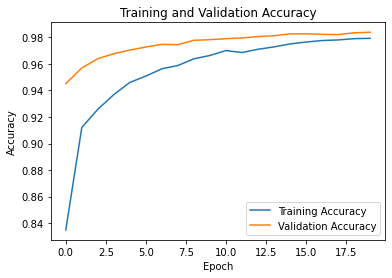

In [19]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

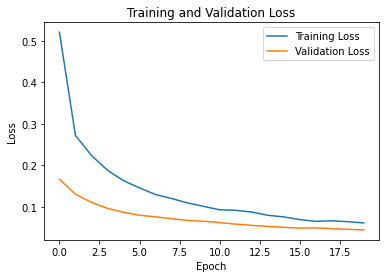

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [5]:
import os
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Define paths to the dataset
train_dir = "./Dataset/train-plant-disease"
valid_dir = "./Dataset/valid-Plant-disease"

datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

#Load the saved model and training history
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

model = load_model('plant_disease_model.keras')






Found 30400 images belonging to 38 classes.
Found 7600 images belonging to 38 classes.
Found 11400 images belonging to 38 classes.


Evaluate the model on the test set and generate predictions

In [6]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Step 4: Generate predictions
y_pred_prob = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

/home/mohi_566357/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 105s 288ms/step - accuracy: 0.9381 - loss: 0.2879
Test Loss: 0.436769038438797
Test Accuracy: 0.9141228199005127
357/357 ━━━━━━━━━━━━━━━━━━━━ 106s 294ms/step


Printing the confusion matrix and classification report

In [7]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[267   4   4 ...   0   0   0]
 [  0 289   0 ...   0   0   0]
 [  0   0 291 ...   0   0   0]
 ...
 [  0   0   0 ... 280   1   0]
 [  0   0   0 ...   1 239   1]
 [  0   0   1 ...   0   0 226]]

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.89      0.92       300
                                 Apple___Black_rot       0.94      0.96      0.95       300
                          Apple___Cedar_apple_rust       0.98      0.97      0.97       300
                                   Apple___healthy       0.96      0.89      0.92       300
                               Blueberry___healthy       0.96      0.97      0.97       300
          Cherry_(including_sour)___Powdery_mildew       0.99      0.97      0.98       300
                 Cherry_(including_sour)___healthy       0.96      0.98      0.97       300
Corn_(maize)___Cercospora_lea

Plot the confusion matrix

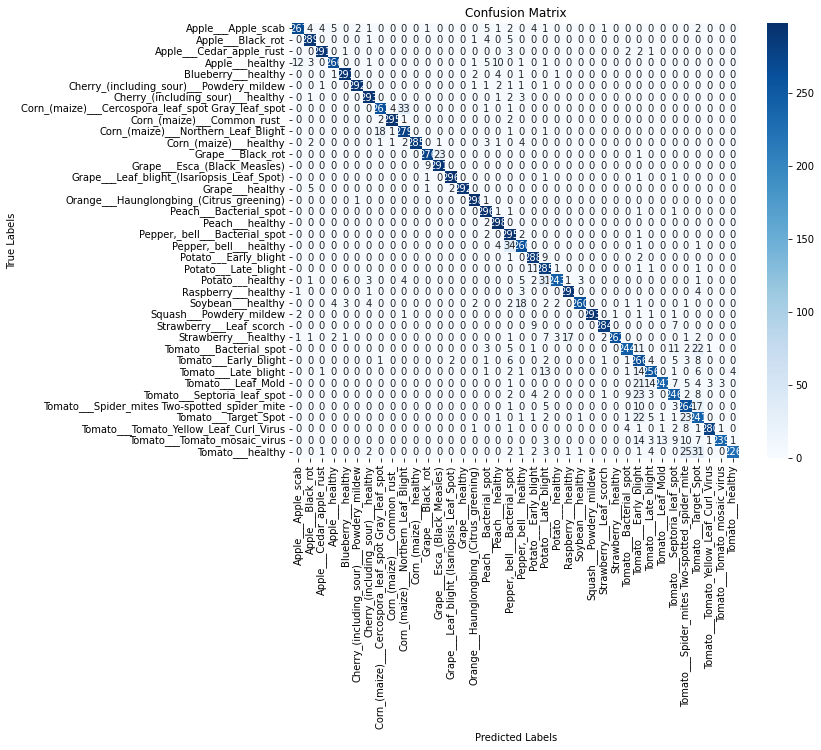

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Make prediction on Unseen Dataset

In [7]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import json

model = load_model('plant_disease_model.keras')

def prepare_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def predict_disease(model, img_array):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class[0]

# Path to the image you want to predict
img_path = '2.jpeg'

img_array = prepare_image(img_path, target_size=(224, 224))  # Replace (224, 224) with your model's input size

# Predict the disease
predicted_class = predict_disease(model, img_array)
print(predicted_class)
# Load the JSON data directly from the dictionary
dic_class_names = {
    "0": "Apple___Apple_scab",
    "1": "Apple___Black_rot",
    "2": "Apple___Cedar_apple_rust",
    "3": "Apple___healthy",
    "4": "Blueberry___healthy",
    "5": "Cherry_(including_sour)___healthy",
    "6": "Cherry_(including_sour)___Powdery_mildew",
    "7": "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "8": "Corn_(maize)___Common_rust_",
    "9": "Corn_(maize)___healthy",
    "10": "Corn_(maize)___Northern_Leaf_Blight",
    "11": "Grape___Black_rot",
    "12": "Grape___Esca_(Black_Measles)",
    "13": "Grape___healthy",
    "14": "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "15": "Orange___Haunglongbing_(Citrus_greening)",
    "16": "Peach___Bacterial_spot",
    "17": "Peach___healthy",
    "18": "Pepper,_bell___Bacterial_spot",
    "19": "Pepper,_bell___healthy",
    "20": "Potato___Early_blight",
    "21": "Potato___healthy",
    "22": "Potato___Late_blight",
    "23": "Raspberry___healthy",
    "24": "Soybean___healthy",
    "25": "Squash___Powdery_mildew",
    "26": "Strawberry___healthy",
    "27": "Strawberry___Leaf_scorch",
    "28": "Tomato___Bacterial_spot",
    "29": "Tomato___Early_blight",
    "30": "Tomato___healthy",
    "31": "Tomato___Late_blight",
    "32": "Tomato___Leaf_Mold",
    "33": "Tomato___Septoria_leaf_spot",
    "34": "Tomato___Spider_mites Two-spotted_spider_mite",
    "35": "Tomato___Target_Spot",
    "36": "Tomato___Tomato_mosaic_virus",
    "37": "Tomato___Tomato_Yellow_Leaf_Curl_Virus"
}

predicted_disease = dic_class_names[str(predicted_class)]

print(f'The predicted disease is: {predicted_disease}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
18
The predicted disease is: Pepper,_bell___Bacterial_spot
